# MODULES AND CONSTANTS

### MODULES, IMPORTS AND LIBRARIES USED

In [1]:
# Generic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Models Regressors
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet


# Metrics
from sklearn.metrics import r2_score, mean_squared_error

### CONSTANTS USED

In [2]:
DATA_PATH = 'SummaryofWeather.csv'

MODELS = [ RandomForestRegressor(n_jobs=-1), MLPRegressor(), DecisionTreeRegressor(), KNeighborsRegressor(n_jobs=-1),
            LinearRegression(n_jobs=-1), Ridge(), Lasso(), ElasticNet()]

METRICS ={r2_score, mean_squared_error}
COLORS_METRICS = {'r2_score':'b', 'mean_squared_error':'r'}

# 1 - READ FILE

Load the Second World War Weather dataset. In particular you have to load the data contained in
SummaryofWeather.csv

In [3]:
def loadDataFrame(path:str):
    return pd.read_csv(filepath_or_buffer=path, header=0, dtype={7:str, 8:str, 18:str, 25:str}).replace({'#VALUE!':np.nan})

# 2 - MISSING VALUES

Inspect the content of the dataset identifying if there are missing values for the sensors in the dataset,
checking for the top 10 most complete sensors (in terms of collected data) the distribution of the
recorded mean temperatures (MeanTemp column).
- Can you identify if these sensors are located in part of the world with similar weather conditions?.
- Is it necessary to normalize the data in this case?
- Which pre-processing step can be useful to solve the forecasting task?

In [4]:
def removeMissingColumns(df:pd.DataFrame)->pd.Series:
    temp = df.isna().sum()
    return df[[k for k in temp.index if temp[k] < df.shape[0]]]

def displayNMostCompleteSensors(df: pd.DataFrame, n:int, printOnScreen:bool=False) -> list[str]:
    res = df.groupby(['STA']).agg('count').sum(axis=1).sort_values(ascending=False).head(n)
    if printOnScreen:
        print(f"Top {n} most active sensors")
        display(res)
        
    return list(res.index)

# 3 - SENSOR SELECTION

For simplicity, we will exploit the data collected by a specific sensor. Filter the data by STA (Station)
and extract the mean temperature measurements corresponding to sensor with id 22508.
<br><br>
Info: Do not forget to keep track also of the date on which each measurements has been taken
and be sure that each date is properly converted to a Datetime data type like the datetime64
type provided by numpy.

In [5]:
def filterDataFrame(df:pd.DataFrame, sensor:int=22508)->pd.DataFrame:
    df = df[df['STA']==sensor][['MeanTemp', 'Date']]
    df['Date'] = pd.to_datetime(df['Date']).convert_dtypes()
    return df

# 4 - TEMPERATURE PLOT

Now you should have an array containing all the measurements collected by sensor 22508 representing the time series of the mean temperatures. Plot the temperatures time series exploiting matplotlib and show on the x axis the corresponding datetime.

In [6]:
def plotTemperature(df:pd.DataFrame)->None:
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.set_title('Temperature')
    plt.plot(df['Date'], df['MeanTemp'])
    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature')
    ax.grid(visible=True)
    ax.set_ylim(bottom=0, top=30)
    plt.show()

# 5 - NEXT DAY PREDICTION

To predict the next day temperature, a rolling window pre-processing should be performed to convert
the time series into a structured dataset. The rolling windows on the time series can be applied by
extracting, from the original time series, a window of length W that moves over the series, with step
1, like the example showed in Figure 3. <br>The dependent variable to be predicted will be the value
positioned at t + W + 1, where t is the position of the rolling window. The final structure of the
dataset extracted with the rolling window will be similar to the one showed in Table 1.

In [7]:
def dataFrameFromSlidingWindow(df:pd.DataFrame, windowSize:int=64) -> pd.DataFrame:
    return pd.DataFrame([[df.iloc[i+j, :]['MeanTemp'] for j in range(df.shape[0]-windowSize)] for i in range(windowSize)]).T

# 6 - DATA SET SPLITTING

Split the dataset into train and test sets and keep in mind that you are evaluating the forecasting of
a time series. To train your model you can consider to use the data from 1940 to 1944 and test the
trained models on 1945 data. <br>
A different way of performing the cross validation on time series is
the TimeSeriesSplit strategy available in Scikit-learn.


In [8]:
def splitTrainTestByYear1945(slideDf:pd.DataFrame, windowSize:int=64)->list[pd.DataFrame]:
    return (slideDf.iloc[:slideDf.shape[0]-365+windowSize,:-1], slideDf.iloc[slideDf.shape[0]-365+windowSize:, :-1], 
            slideDf.iloc[:slideDf.shape[0]-365+windowSize, -1], slideDf.iloc[slideDf.shape[0]-365+windowSize:, -1])

# 7 - REGRESSION MODEL EVALUATION

Now, using the regression techniques that you have learned, try to identify which is the most accurate
regression model evaluating the r2_score and the mean_squared_error.


In [9]:
def evaluateModel(model:DecisionTreeRegressor, xTest: pd.DataFrame, yTest: pd.DataFrame, metrics: list=METRICS):
    yPred = model.predict(xTest)    
    return pd.Series(list(map(lambda fun: fun(yTest, yPred), metrics)), index=list(map(lambda x:str(x).split()[1], metrics)),
                        name=str(model).split('(')[0])


def trainTestModels(xTrain:pd.DataFrame, xTest:pd.DataFrame, yTrain:pd.DataFrame, yTest:pd.DataFrame, 
                    models:list[DecisionTreeRegressor]=MODELS, metrics:list=METRICS, plotRes: bool=False, 
                    colors: dict=COLORS_METRICS)->pd.DataFrame:
    res = pd.DataFrame([evaluateModel(model.fit(xTrain, yTrain), xTest, yTest, metrics) for model in models])
    
    if plotRes:
        fig, ax = plt.subplots() 
        bar_width = 0.35 
        index = np.arange(len(res)) 
        
        for i, col in enumerate(res.columns): 
            ax.barh(index + bar_width * i, res[col], bar_width, label=col, color=colors[col]) 
        
        ax.set_ylabel('Models') 
        ax.set_xlabel('Values') 
        ax.set_title('Model Performances') 
        ax.set_yticks(index + bar_width / 2) 
        ax.set_yticklabels(res.index) 
        ax.legend()
        plt.show()
        
    return res

# 8 - PREDICTION VISUALIZATION

To visualize the forecasted time series with respect to the real test time series, plot the test values
and the forecasted values on the same chart.
- Are the two series similar?
- Have the seasonality and the trend of the series been correctly predicted?
- Are you able to predict a horizon longer than 1 day with this kind of techniques? Why?

In [10]:
def plotPredictionVsReal(xTrain:pd.DataFrame, xTest:pd.DataFrame, yTrain:pd.DataFrame, yTest:pd.DataFrame, 
                            models:list[RandomForestRegressor]=MODELS):
    
    models = [model.fit(xTrain, yTrain) for model in models]
    
    
    plt.scatter(list(range(yTest.shape[0])), yTest.set_axis(labels=list(range(yTest.shape[0])), axis=0), marker='x', label='real')
    plt.scatter(list(range(yTest.shape[0])), pd.DataFrame(model.predict(xTest) for model in models).mean(axis=0), marker='o', label='predicted') 
    plt.xlabel('Time') 
    plt.ylabel('Temperature C') 
    plt.title('Predicted vs Real temperature')
    plt.grid(visible=True)
    plt.legend() 
    plt.show()    

# 9 - HYPER PARAMETERS TESTING

Try to change the pre-processing step and the hyper-parameters of the pipeline and repeat the analysis to see how your model performance will change.

# MAIN FUNCTION

This is the main function of the file, it does:
<ol>
<li>Load the data frame and removes the np.nan columns</li>
<li>Looks for the most complete sensors</li>
<li>Filters the dataframe for a specific sensor</li>
<li>Plot the temperature time series</li>
<li>Sliding window for future prediction</li>
<li>Divides the data set into a train and a test one, based on a given year</li>
<li>Trains and test the models</li>
<li>Visualize the final prediction</li>
<li>Test new hyperparameters</li>
</ol>

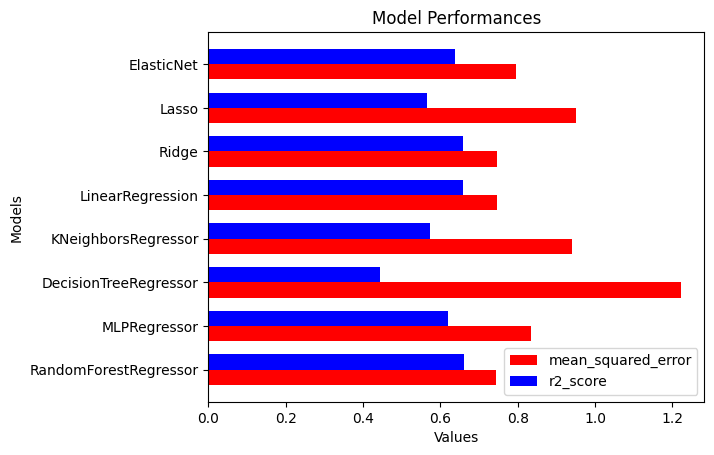

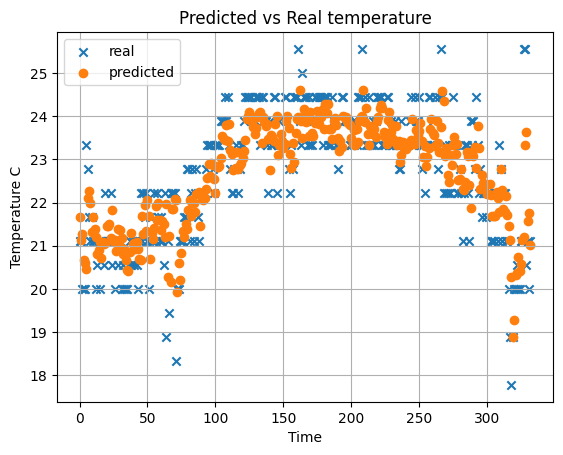

c:\Users\utente\OneDrive\Desktop\Magistrale\01TWZSM_DataScienceLab\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


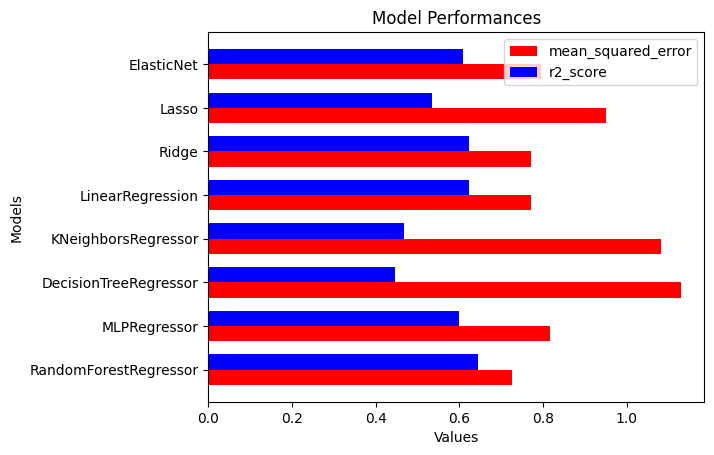

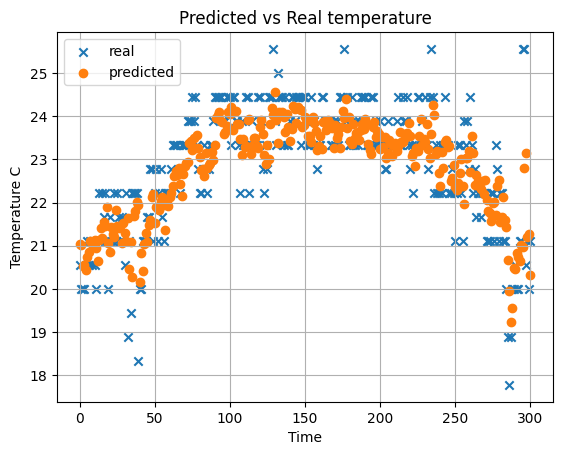

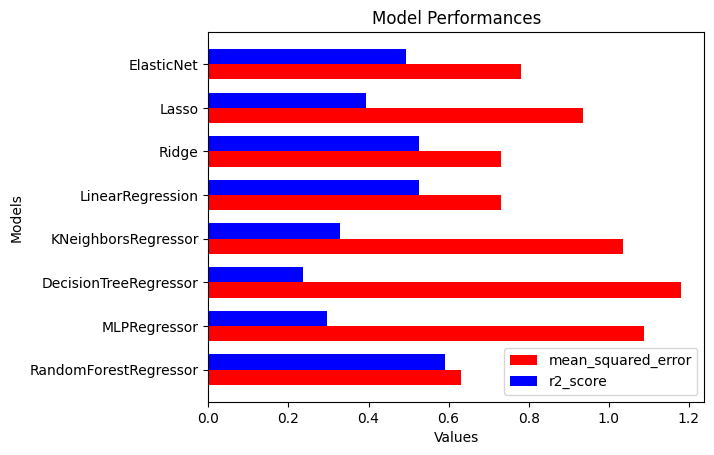

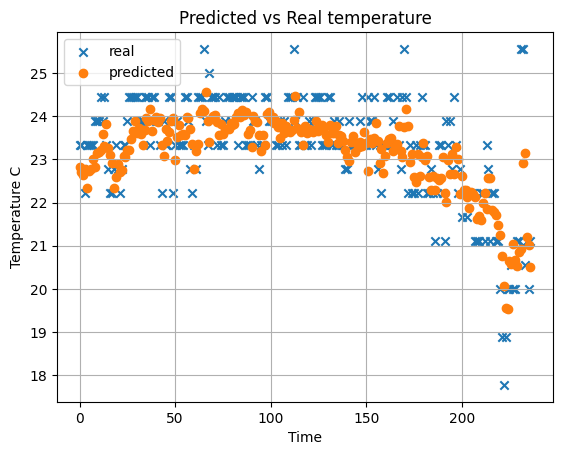

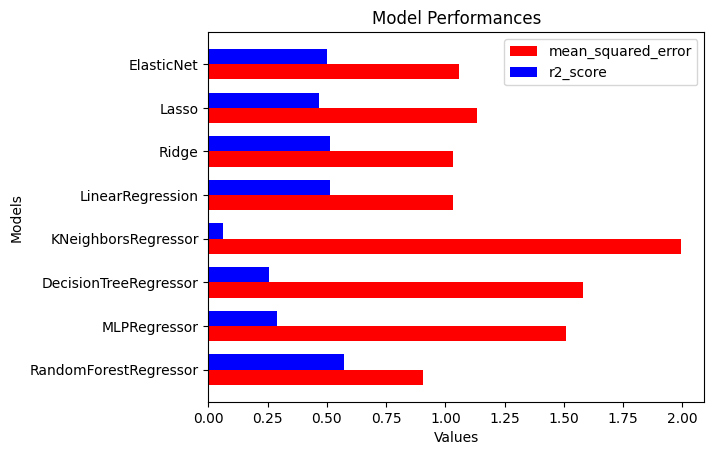

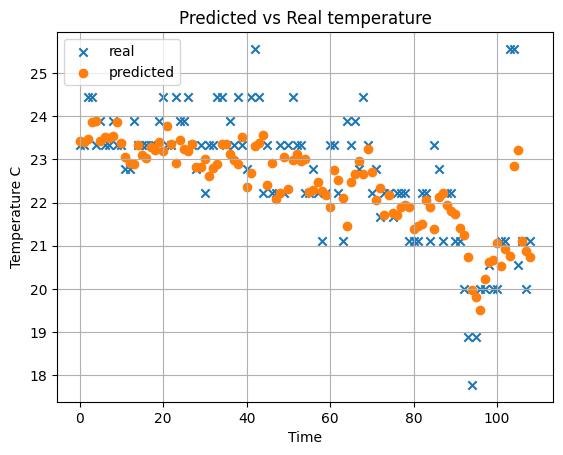

In [ ]:
def main(slidingWindowSize: list[int] = None) -> None:
    for val in slidingWindowSize or [64]: # 9
        df = removeMissingColumns(loadDataFrame(DATA_PATH)) # 1,2
        # print(df[df['STA'].isin(displayNMostCompleteSensors(df, 10))][['STA','MeanTemp']].groupby('STA').agg('mean')) # 2
        df = filterDataFrame(df, 22508) # 3
        # plotTemperature(df) # 4
        newDf = dataFrameFromSlidingWindow(df, val) # 5

        xTrain, xTest, yTrain, yTest = splitTrainTestByYear1945(newDf, val) # 6

        trainTestModels(xTrain, xTest, yTrain, yTest, MODELS, METRICS, plotRes=True, colors=COLORS_METRICS) # 7

        plotPredictionVsReal(xTrain, xTest, yTrain, yTest, MODELS) # 8
        
main([32, 64, 128, 256])